# Framingham Heart Study: Predicting onset of CHD

## Introduction
According to the World Health Organization (WHO), an estimated 12 million deaths occur as a result of heart and cardiovascular disease. Early detection of heart disease can be informative in making lifestyle and eating changes in high risk patients, therefore reducing risk of disease and future complications. 

The dataset is open source and publicly available [here](https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset) and is from an ongoing cardiovascular study on folks from Framingham, Massachussetts. The goal of this project aims to determine the most relevant risk factors of heart disease as well as predict overall risk of being diagnosed with CHD (coronary heart disease) using 15 attributes (demographic, behavioral and medical). 

### Importing Libraries

In [236]:
#Data loading and visualization 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Feature selection 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif

#Data scaling 
from sklearn.preprocessing import MinMaxScaler

#Data balancing 
from imblearn.over_sampling import SMOTE

#Data splitting
from sklearn.model_selection import train_test_split

#Data modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC

#Model hypertuning
from sklearn.model_selection import RandomizedSearchCV

#Data model results
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve, classification_report

### Reading Dataset

In [237]:
fhs = pd.read_csv('/Users/harikapanuganty/Desktop/framingham.csv')
fhs.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [238]:
fhs.shape

(4240, 16)

In [239]:
fhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


### Variables
#### Demographic:
* **sex**: Male or Female (binary)
    * Column name is male, 1 = male and 0 = female 
* **age**: Patient age (continuous though ages in this dataset are rounded to nearest whole number) 
* **education**: No information 

#### Behavioral: 
* **currentSmoker**: 1 = current smoker, 0 = not a current smoker (binary)
* **cigsPerDay**: Number of cigarettes person smoked on average in one day (continuous i.e., half a cigarette)

#### Medical History 
* **BPMeds**: 1 = patient was in BP medication, 0 = patient is not on any BP medication (binary)
* **prevalentStroke**: 1 = patient has history of stroke, 0 = patient has no history of stroke (binary)
* **prevalentHyp**: 1 = patient has history of hypertension, 0 = patient has no history of hypertension (binary) 
* **diabetes**: 1 = patient has history of diabetes, 0 = patient has no history of diabetes (binary)

#### Current Medical 
* **totChol**: patient cholesterol level (continuous)
* **sysBP**: patient systolic blood pressure (continuous)
* **diaBP**: patient dyastolic blood pressure (continuous)
* **BMI**: patient Body Mass Index (continuous)
* **heartRate**: patient Heart Rate (continuous though heartRate in this dataset are rounded to nearest whole number) 
* **glucose**: patient glucose level (continuous)

#### Target to predict: 
* **TenYearCHD**: 10 year-risk of developing coronary heart disease (CHD): 1 = yes, 0 = no (binary)

### Data Cleaning

In [240]:
fhs.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

The output above indicates the number of null/missing values in each column of our dataset. 
- Education: 105 
- cigsPerDay: 29
- BPMeds: 53
- totChol: 50
- BMI: 19
- heartRate: 1
- glucose: 388

Based on the column and number of missing values, we will handle missing values accordingly. 
- `heartRate` is missing only one value, so we will drop the missing row
- `cigsPerDay`, `totChol` and `BPMeds` are missing a few dozen values so we will replace missing values with the column mean
- choosing to interpolate missing values for `BMI` and `glucose`
- Realistically, level of `education` does not seem to be relevant to developing heart disease so we will choose to remove all missing rows and evaluate status of the column at a later time

In [241]:
fhs = fhs.dropna(subset = ['heartRate'])

In [242]:
fhs['cigsPerDay'].fillna(int(fhs['cigsPerDay'].mean()), inplace=True)

In [243]:
fhs['totChol'].fillna(int(fhs['totChol'].mean()), inplace=True)

In [244]:
fhs['BPMeds'].fillna(int(fhs['BPMeds'].mean()), inplace=True)

In [245]:
fhs['BMI'].interpolate(method='pad', direction = 'forward', inplace=True) #according to documentation, 'pad' fills in NaN's using existing values 

In [246]:
fhs['glucose'].interpolate(method='pad', direction = 'forward', inplace=True) #according to documentation, 'pad' fills in NaN's using existing values 

In [247]:
fhs.dropna(subset = ['education'], inplace=True)

In [248]:
fhs.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## Exploratory Data Analysis

#### Boxplot
Boxplots represent groups of numerical data through *quartiles* and can help identify outliers in a dataset. In a boxplot:
- The bottom black line in a boxplot is the *minimum* value and the first black line is the *maximum* value
- First black line is the *first quartile* (25%), second black line is the *second quartile* (50%) and third black line is the *third quartile* (75%)
- Black diamond shapes above each plot are the outliers

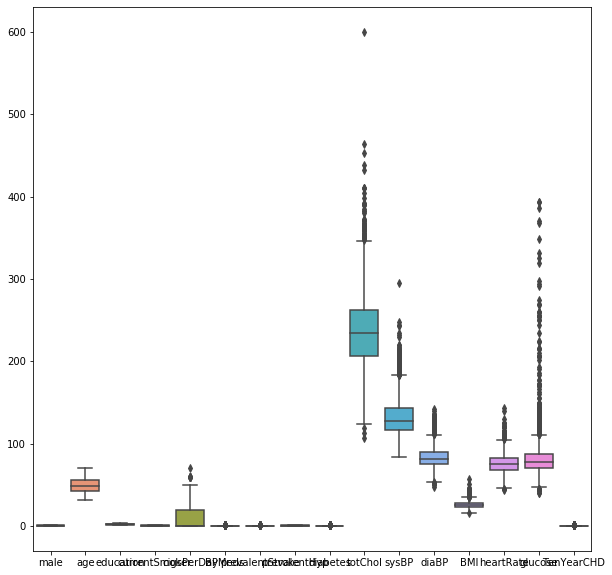

In [249]:
plt.figure(figsize=(10,10))
sns.boxplot(data=fhs)
plt.show()

Extreme outliers are detected in the `totChol` and `sysBP` columns of the dataset and need to be removed. Outliers in other columns contain important information and will not be removed

**Identifying and removing outliers in totChol and sysBP columns**

In [250]:
fhs['totChol'].max()

600.0

In [251]:
fhs['sysBP'].max()

295.0

In [252]:
fhs = fhs[fhs['totChol']<600.0]
fhs = fhs[fhs['sysBP']<295.0]
fhs.shape

(4132, 16)

In [253]:
fhs.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000
mean,0.427396,49.544773,1.979913,0.494918,9.034850,0.029284,0.006050,0.310745,0.025411,236.542594,132.313650,82.863262,25.765167,75.918441,81.921830,0.151258
std,0.494760,8.559540,1.019934,0.500035,11.889886,0.168621,0.077558,0.462855,0.157390,43.559411,21.924953,11.927089,4.076952,12.048614,23.881139,0.358344
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.050000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.360000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,143.500000,89.500000,27.982500,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,464.000000,248.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Descriptive statistics summarizing mean, std deviation, percentiles and count for the updated dataset. Generating this table after removing missing values and outliers gives us a better understanding of the dataset that we are working with. 

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.029213,0.017497,0.198606,0.319838,-0.051402,-0.004321,0.004465,0.019036,-0.071709,-0.035603,0.057696,0.082428,-0.116788,0.000042,0.084486
age,-0.029213,1.000000,-0.165726,-0.212492,-0.192349,0.124126,0.058847,0.308287,0.101487,0.269168,0.393684,0.207674,0.133110,-0.009716,0.119453,0.226940
education,0.017497,-0.165726,1.000000,0.018548,0.008302,-0.010654,-0.035186,-0.081125,-0.039043,-0.023723,-0.128316,-0.061227,-0.136107,-0.053891,-0.031281,-0.053281
currentSmoker,0.198606,-0.212492,0.018548,1.000000,0.767733,-0.048477,-0.033538,-0.106134,-0.039883,-0.044929,-0.129422,-0.107658,-0.159032,0.058252,-0.049547,0.017125
cigsPerDay,0.319838,-0.192349,0.008302,0.767733,1.000000,-0.045787,-0.033305,-0.069620,-0.033977,-0.024544,-0.089545,-0.055517,-0.087427,0.072229,-0.055375,0.054442
BPMeds,-0.051402,0.124126,-0.010654,-0.048477,-0.045787,1.000000,0.116020,0.258675,0.044924,0.083393,0.255171,0.193311,0.098826,0.017499,0.050584,0.090932
prevalentStroke,-0.004321,0.058847,-0.035186,-0.033538,-0.033305,0.116020,1.000000,0.075737,0.007233,0.000389,0.058176,0.045905,0.026742,-0.018123,0.016070,0.062874
prevalentHyp,0.004465,0.308287,-0.081125,-0.106134,-0.069620,0.258675,0.075737,1.000000,0.074340,0.162872,0.699156,0.618107,0.298476,0.150134,0.081257,0.177742
diabetes,0.019036,0.101487,-0.039043,-0.039883,-0.033977,0.044924,0.007233,0.074340,1.000000,0.028778,0.109614,0.048404,0.079761,0.046410,0.576493,0.094931
totChol,-0.071709,0.269168,-0.023723,-0.044929,-0.024544,0.083393,0.000389,0.162872,0.028778,1.000000,0.210758,0.167218,0.115543,0.089911,0.051066,0.079602


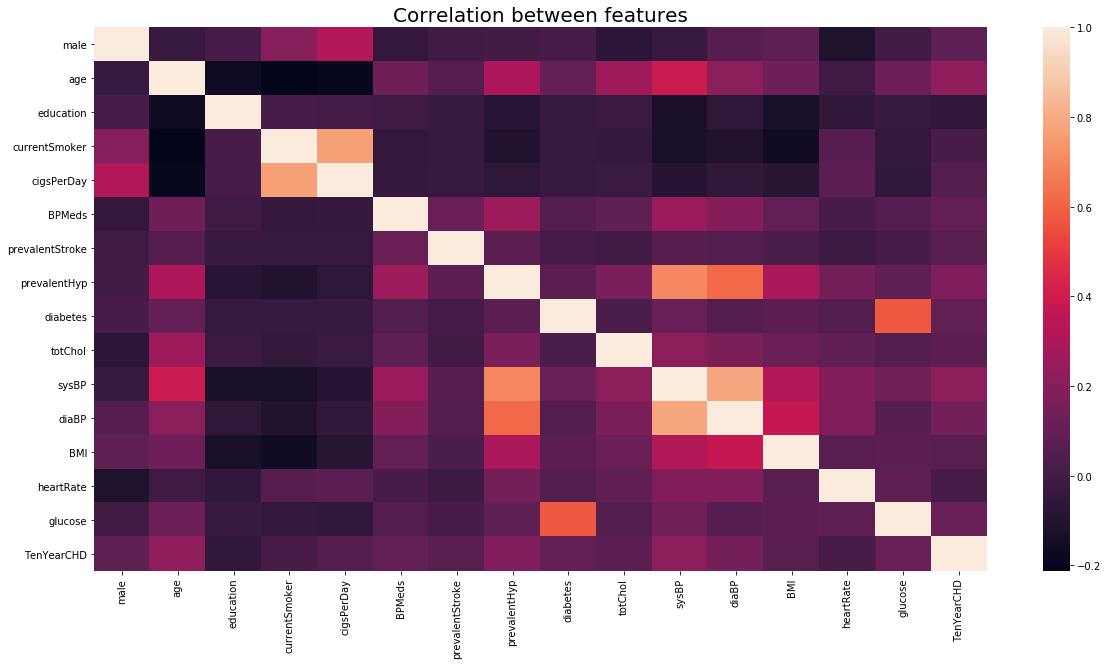

In [254]:
fhs_corr = fhs.corr()
plt.figure(figsize=(20,10))
sns.heatmap(fhs_corr)
plt.title("Correlation between features", size=20)
fhs_corr

**Reading and understanding Heatmaps**
- Correlation range is -1 to +1
- Closer to 0 = no linear trend
- Closer to +1 = positively correlated
- Closer to -1 = negatively correlated 

Looking at the table and plot above we see that `Education` is VERY close to 0, indicating there's no relationship between that variable and the outcome so we will choose to *drop that column*

In [255]:
fhs = fhs.drop(['education'], axis=1)

### Univariate Analysis

#### Categorical variables
Deeper understanding each of the categorical variables including the target variable

In [256]:
categorical_vars_fhs = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

In [257]:
for var in categorical_vars_fhs:
    print(var)
    print(fhs[var].value_counts())

male
0    2366
1    1766
Name: male, dtype: int64
currentSmoker
0    2087
1    2045
Name: currentSmoker, dtype: int64
BPMeds
0.0    4011
1.0     121
Name: BPMeds, dtype: int64
prevalentStroke
0    4107
1      25
Name: prevalentStroke, dtype: int64
prevalentHyp
0    2848
1    1284
Name: prevalentHyp, dtype: int64
diabetes
0    4027
1     105
Name: diabetes, dtype: int64
TenYearCHD
0    3507
1     625
Name: TenYearCHD, dtype: int64


From the **categorical variables**, we can deduce that:
- `BPMeds`, `prevalentStroke`, `diabetes` and the *target variable* `TenYearCHD` are imbalanced 
- Within `currentSmoker`, number of smokers = number of non-smokers

#### Numeric variables
Distplots for each variable to show frequency distribution and potential skew

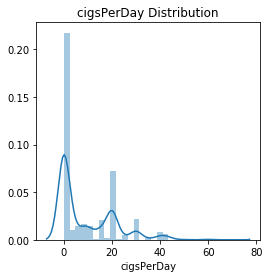

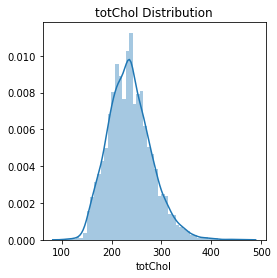

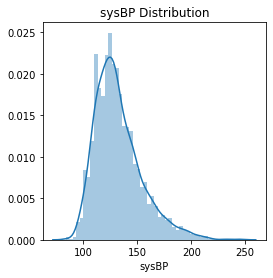

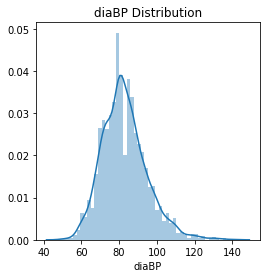

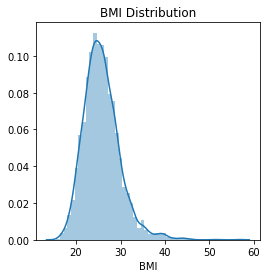

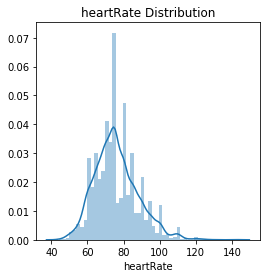

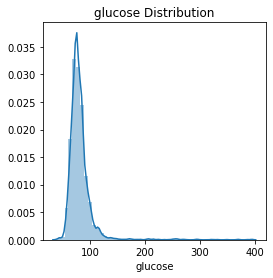

In [258]:
numeric_vars_fhs = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for var in numeric_vars_fhs:
    plt.figure(figsize=(4,4))
    sns.distplot(fhs[var])
    plt.title('{} Distribution'.format(var))
    plt.show()

From the **numerical** variables, we can deduce that:
- `totChol`, `sysBP`, `diaBP`, `BMI`, and `glucose` are normally distributed 
- `cigsPerDay` is highly unevenly (right skew) distributed, with most records nearing 0 

### Bivariate Analysis

Looking into the relationship between two variables 

**Relationship between gender and risk of developing CHD** using a simple bar plot

In [259]:
gender_graph = fhs.groupby("male", as_index=False).TenYearCHD.sum()

Text(0, 0.5, 'TenYearCHD cases')

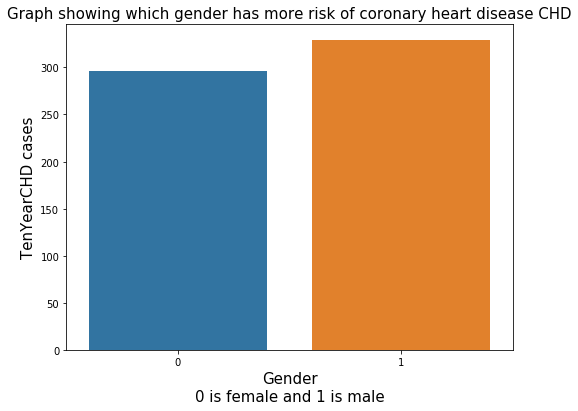

In [260]:
plt.figure(figsize=(8,6))
sns.barplot(x=gender_graph["male"], y=gender_graph["TenYearCHD"])
plt.title("Graph showing which gender has more risk of coronary heart disease CHD", size=15)
plt.xlabel("Gender\n0 is female and 1 is male",size=15)
plt.ylabel("TenYearCHD cases", size=15)

**Relationship between cigsPerDay and risk of developing CHD**
using Seaborn's countplot to show the counts of observations in each categorical 'bin' using bars 

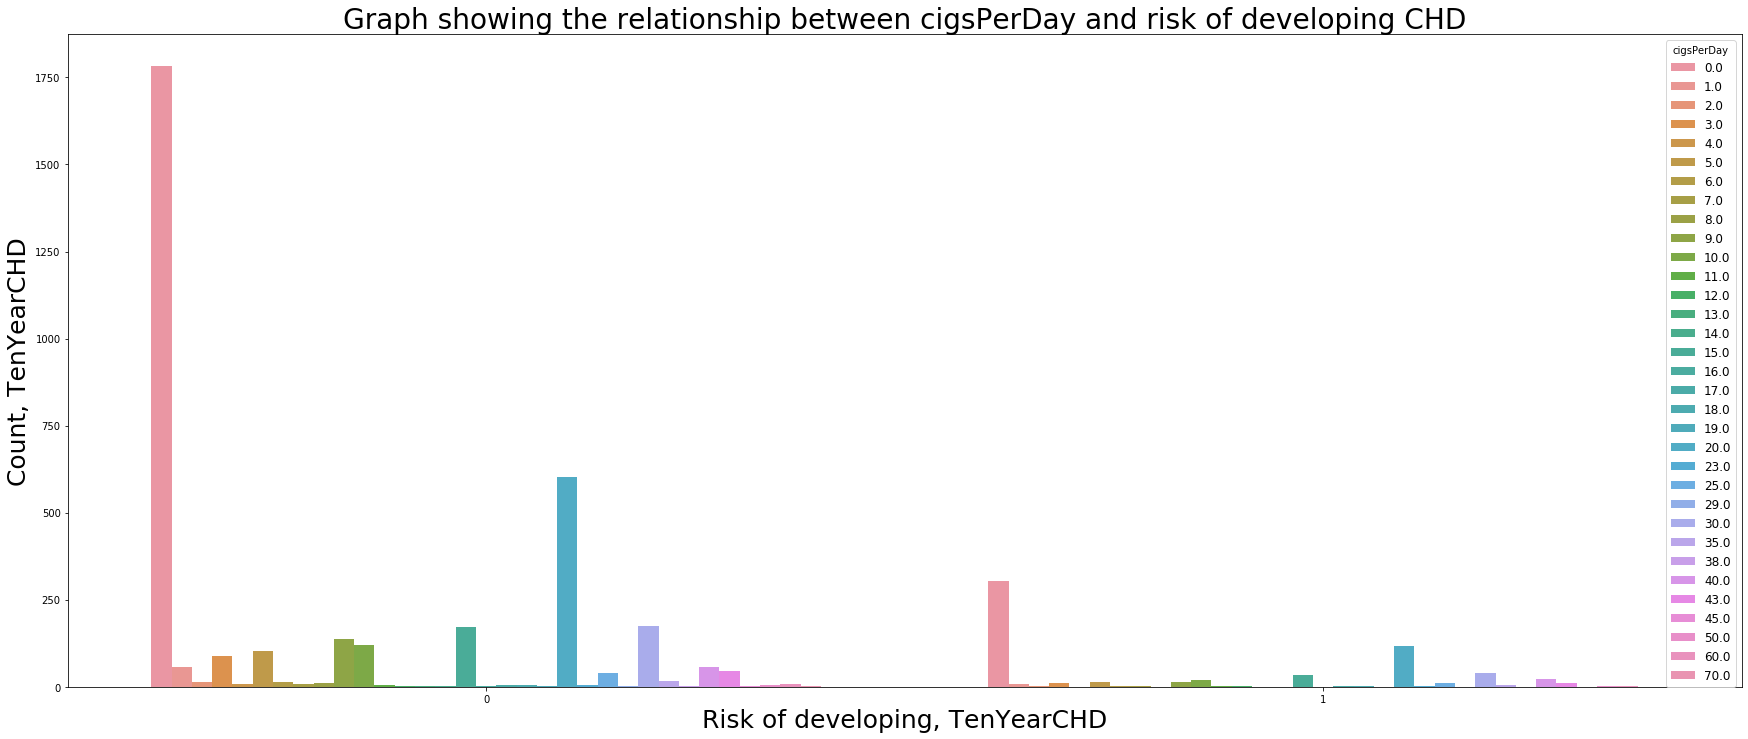

In [261]:
plt.figure(figsize=(30,12), facecolor='w')
sns.countplot(x='TenYearCHD', data=fhs, hue='cigsPerDay')
plt.legend(title = 'cigsPerDay', fontsize='large')
plt.title("Graph showing the relationship between cigsPerDay and risk of developing CHD", size=28)
plt.xlabel("Risk of developing, TenYearCHD", size=25)
plt.ylabel("Count, TenYearCHD", size=25)
plt.show()

- The more `cigsPerDay` an individual smokes, the greater the chance of developing `TenYearCHD` 
- Individuals who do not smoke or smoke just a few `cigsPerDay` have a very low risk of developing `TenYearCHD`

**Relationship between sysBP and risk of developing CHD** using a simple bar plot 

Text(0, 0.5, 'SysBP')

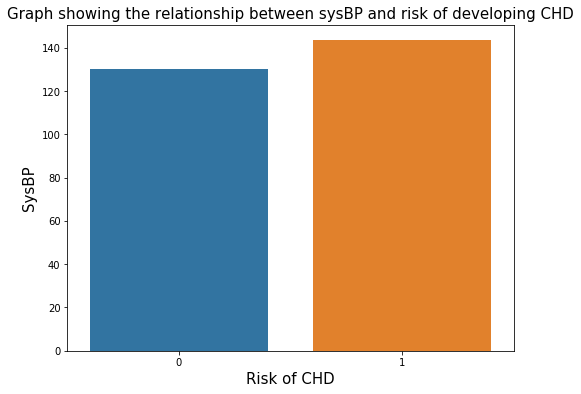

In [262]:
sysbp_graph = fhs.groupby("TenYearCHD", as_index=False).sysBP.mean() 
plt.figure(figsize=(8,6))
sns.barplot(x=sysbp_graph["TenYearCHD"], y=sysbp_graph["sysBP"])
plt.title("Graph showing the relationship between sysBP and risk of developing CHD", size=15)
plt.xlabel("Risk of CHD", size=15)
plt.ylabel("SysBP", size=15)

Text(0.5, 1.0, 'Distribution of sysBP in relation to developing CHD')

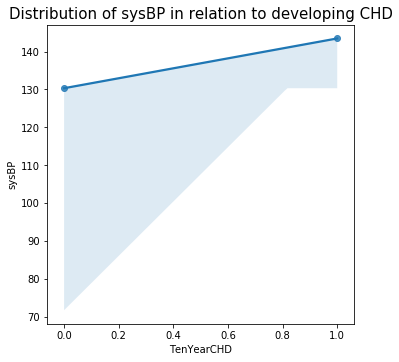

In [263]:
plt.figure(figsize=(5.5,5.5))
sns.regplot(x=sysbp_graph["TenYearCHD"], y=sysbp_graph["sysBP"])
plt.title("Distribution of sysBP in relation to developing CHD", size=15)

The trendline we see in the regplot is linearly increasing which indicates that there is a positive correlation between sysBP and risk of CHD, **risk of developing CHD increases as sysBP increases**

Text(0, 0.5, 'DiaBP')

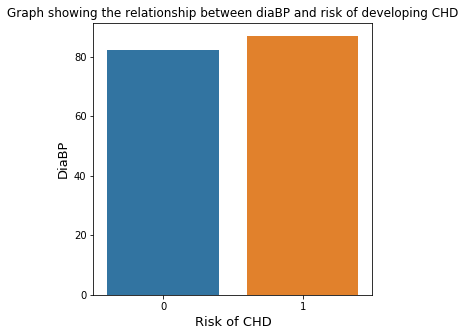

In [264]:
diabp_graph = fhs.groupby("TenYearCHD", as_index=False).diaBP.mean() 
plt.figure(figsize=(5,5))
sns.barplot(x=diabp_graph["TenYearCHD"], y=diabp_graph["diaBP"])
plt.title("Graph showing the relationship between diaBP and risk of developing CHD", size=12)
plt.xlabel("Risk of CHD", size=13)
plt.ylabel("DiaBP", size=13)

Text(0.5, 1.0, 'Distribution of diaBP in relation to developing CHD')

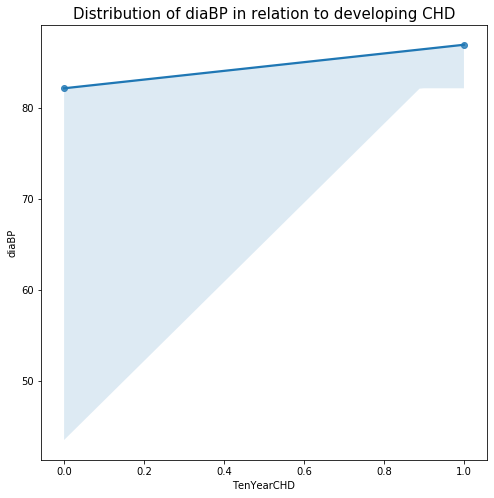

In [265]:
plt.figure(figsize=(8,8))
sns.regplot(x=diabp_graph["TenYearCHD"], y=diabp_graph["diaBP"])
plt.title("Distribution of diaBP in relation to developing CHD", size=15)

The trendline we see in the regplot is linearly increasing which indicates that there is a positive correlation between diaBP and risk of CHD, **risk of developing CHD increases as diaBP increases**

### Feature Selection 

With feature selection, we're able to *include only relevant features* in our machine learning models. Irrelevant, or partially relevant, features can negatively impact our model performance if not removed. The process of feature selection includes ***choosing features that contribute most to the prediction output.***

There are different ways of finding the right feature selection technique for a dataset: we can filter based on type of learning (supervised vs unsupervised) or input/output variable (numerical vs categorial). 

For this project, we will use two feature selection methods:
- ***SelectKBest***: consider this to be a kind of 'wrapper' since we can indicate what function we would like to use in feature selection. This project utilized chi2 so SKB calculates the chi-squared statistic between each feature of X and y class labels and returns the first k features of X with the highest scores.

- ***Mutual Information Classification***: can estimate information for a discrete target variable by measuring the dependency of features with the target variable. A higher score indicates the more dependent the variable.

This [article](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/) and this [article](https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31cis) are great resources that dive deeper into feature selection for a dataset and implementation of feature selection methods, respectively. 

In [266]:
X = fhs.iloc[:,0:14]
y = fhs.iloc[:,-1]
print("X = ", X.shape, "y = ", y.shape)

X =  (4132, 14) y =  (4132,)


In [267]:
bestfeatures_skb = SelectKBest(score_func=chi2, k=8) 
fit_skb = bestfeatures_skb.fit(X,y) 
dfscores = pd.DataFrame(fit_skb.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

           Specs       Score
9          sysBP  691.655722
13       glucose  356.832707
1            age  314.614421
8        totChol  209.969950
3     cigsPerDay  191.581223
10         diaBP  146.711990
6   prevalentHyp   89.974858
7       diabetes   36.291237
4         BPMeds   33.165316
0           male   16.888078


In [268]:
threshold = 10  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=1)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
feature_scores_mic = X[high_score_features]

age 0.01858692710302612
prevalentHyp 0.017625283311859086
sysBP 0.014623253740561282
diaBP 0.009130359317964132
totChol 0.0074803461066887955
BMI 0.006362003023155927
male 0.0051569594968869925
heartRate 0.004573151282309285
BPMeds 0.0022342451846886213
diabetes 0.0014005392758120738


SelectKBest indicates that sysBP, glucose, age, totChol, cigsPerDay, diaBP, prevalentHyp, diabetes, BPMeds and male are the features that strongly influence the target outcome. 

Mutual Classification Information results are slightly different and indicates that age, prevalentHyp, sysBP, diaBP, totChol, BMI, male, heartRate, BPMeds and diabetes are the features that strongly influence the target outcome.

Using a combination of the results from both of these methodologies, the features that will be used in predictive modelling will be `sysBP`, `age`, `totChol`, `diaBP`, `prevalentHyp`, `diabetes`, `BPMeds` and `male`.


In [269]:
fhs = fhs[['sysBP', 'age', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male','TenYearCHD' ]]
fhs.head()

,sysBP,age,totChol,diaBP,prevalentHyp,diabetes,BPMeds,male,TenYearCHD
0,106.0,39,195.0,70.0,0,0,0.0,1,0
1,121.0,46,250.0,81.0,0,0,0.0,0,0
2,127.5,48,245.0,80.0,0,0,0.0,1,0
3,150.0,61,225.0,95.0,1,0,0.0,0,1
4,130.0,46,285.0,84.0,0,0,0.0,0,0


### Train Test Split

In [270]:
X = fhs.drop(['TenYearCHD'], axis=1) #2D input array
y = fhs['TenYearCHD'] #1D input array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

### Feature Scaling

Scaling ensures that higher ranging and lower ranging numbers in the features of the dataset have the ***same 'weight' in the model.*** Feature scaling is essential for machine learning algorithms that calculate distances between data (this project will incorporate all models, including those dependent on data distance). 

We will be using **Min Max Scaler** since the ***distribution of our data is normal*** and as we've ***removed sensitive outliers.*** 

In [271]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Resampling imbalanced target variable

From the earlier univariate analysis, we can see that the target variable is ***highly imbalanced***. If we use this imbalanced variable to predict, **our models will favor the majority class and choose to ignore the minority class** resulting in *high accuracy but low recall* models. To help balance the classes, we will use the **'SMOTE'** (Synthetic Minority Oversampling Technique) method which oversamples the minority class by synthesizing new samples from existing ones. 

In [272]:
sm = SMOTE(random_state=1)
X_sm, y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nNumber of positive and negative instances in both classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4132, 8)
Shape of X after SMOTE: (7014, 8)

Number of positive and negative instances in both classes (%):


1    50.0
0    50.0
Name: TenYearCHD, dtype: float64

So far we’ve explored the dataset, identified and removed outliers, analyzed our categorical and numerical variables in depth, appropriately divided our data into testing and training datasets, scaled our features, selected our features (using SelectKBest and Mutual Information Classification) and balanced our target variable using SMOTE. 

***We are now ready to apply machine learning algorithms.***

### Predictive Modeling 

#### Logistic Regression

In [273]:
lr = LogisticRegression(random_state=25, max_iter=100) 
lr_model = fhs_lr.fit(X_train, y_train)
lr_predict = fhs_lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predict) 
lr_cm = confusion_matrix(y_test, lr_predict)
print("Accuracy of Logistic Regression:", lr_accuracy)
print("Logistic Regression Confusion Matrix:", lr_cm)
print(classification_report(y_test, lr_predict))

Accuracy of Logistic Regression: 0.841596130592503
Logistic Regression Confusion Matrix: [[693   3]
 [128   3]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       696
           1       0.50      0.02      0.04       131

    accuracy                           0.84       827
   macro avg       0.67      0.51      0.48       827
weighted avg       0.79      0.84      0.78       827



#### Random Forest Classification

In [274]:
rf = RandomForestClassifier(n_estimators=100, random_state=25, max_depth=12)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predict)
rf_cm = confusion_matrix(y_test, rf_predict)
print("Accuracy of Random Forest:", rf_accuracy)
print("Random Forest Confusion Matrix:", rf_cm)
print(classification_report(y_test, rf_predict))

Accuracy of Random Forest: 0.841596130592503
Random Forest Confusion Matrix: [[688   8]
 [123   8]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       696
           1       0.50      0.06      0.11       131

    accuracy                           0.84       827
   macro avg       0.67      0.52      0.51       827
weighted avg       0.79      0.84      0.79       827



#### K-Nearest Neighbors

In [293]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predict)
knn_accuracy = accuracy_score(y_test, knn_predict)
print("Accuracy of KNN Classification:", knn_accuracy)
print("KNN Classification Confusion Matrix:", knn_cm)
print(classification_report(y_test, knn_predict))

Accuracy of KNN Classification: 0.8307134220072552
KNN Classification Confusion Matrix: [[673  23]
 [117  14]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       696
           1       0.38      0.11      0.17       131

    accuracy                           0.83       827
   macro avg       0.62      0.54      0.54       827
weighted avg       0.78      0.83      0.79       827



#### Support Vector Machine 

In [294]:
svm = SVC()
svm_model = svm.fit(X_train, y_train)
svm_predict = svm.predict(X_test)
svm_cm = confusion_matrix(y_test, svm_predict)
svm_accuracy = accuracy_score(y_test, svm_predict)
print("Accuracy of SVM Classification:", svm_accuracy)
print("SVM Classification Confusion Matrix:", svm_cm)
print(classification_report(y_test, svm_predict))

Accuracy of SVM Classification: 0.841596130592503
SVM Classification Confusion Matrix: [[695   1]
 [130   1]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       696
           1       0.50      0.01      0.02       131

    accuracy                           0.84       827
   macro avg       0.67      0.50      0.46       827
weighted avg       0.79      0.84      0.77       827



#### Hypertuned Random Forest Classification

In [275]:
#adjusting RF hyperparameters by creating a parameter grid to sample while fitting

# Number of trees in forest 
n_estimators = [int(x) for x in np.linspace(start= 100, stop = 1000, num = 10)] #no. of trees ranges from 100-1000 in intervals of 20

# Max number of features needed before each split
max_features = ["auto", "sqrt"]

# Max no. of levels in each tree
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num = 10)] #no. of trees ranges from 10-100 in intervals of 10
max_depth.append(None)

# Min no. of samples needed to split a node  
min_samples_split = [2, 5, 10]

# Min no. of samples needed at each node 
min_samples_leaf = [1, 2, 4]

# Method of choosing samples for training each tree
bootstrap = [True, False]

# Create the random grid
rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(rf_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [276]:
#Create base model to tune and use random grid to find best hyperparameters 
rf_hyp = RandomForestClassifier()

#Random search of parameters through 3-Fold cross-validation 
rf_hyp_rs = RandomizedSearchCV(estimator=rf_hyp, param_distributions = rf_grid, n_iter=100, cv=3, verbose=2, random_state=25, n_jobs=-1)

#Fit random search model
rf_hyp_rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [277]:
#Comparing the random search random forest model to the base random forest model 
rf_hyp_model = rf_hyp_rs.best_estimator_
rf_hyp_model.fit(X_train, y_train)
rf_hyp_predict = rf_hyp_model.predict(X_test)
rf_hyp_cm = confusion_matrix(y_test, rf_hyp_predict)
rf_hyp_accuracy = accuracy_score(y_test, rf_hyp_predict)
print("Accuracy of Hypertuned Random Forest:", rf_hyp_accuracy)
print("Hypertuned Random Forest:", rf_hyp_cm)
print(classification_report(y_test, rf_hyp_predict))

Accuracy of Hypertuned Random Forest: 0.8440145102781137
Hypertuned Random Forest: [[695   1]
 [128   3]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       696
           1       0.75      0.02      0.04       131

    accuracy                           0.84       827
   macro avg       0.80      0.51      0.48       827
weighted avg       0.83      0.84      0.78       827



#### Hypertuned K-Nearest Neighbors Classification

In [279]:
# affects speed and memory of query, passed on to algorithm (balltree or kdtree)
leaf_size= list(range(1,50))

# Number of neighbors 
n_neighbors= list(range(1,30))

# minkowski metric power parameter 
p= [1,2]

#creating the dict 'grid'
knn_hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)


In [280]:
#Create base model to tune and use grid to find best hyperparameters 
knn_hyp_obj = KNeighborsClassifier() 

#Random search of parameters through 3-Fold cross-validation 
knn_hyp_grid = RandomizedSearchCV(knn_hyp_obj, knn_hyperparameters, random_state = 25, cv=3, n_jobs=-1)

#Fit random search model
knn_hyp_model = knn_hyp_grid.fit(X_train, y_train)

In [281]:
#Print The value of best Hyperparameters
print('Best leaf_size:', knn_hyp_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', knn_hyp_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knn_hyp_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 20
Best p: 1
Best n_neighbors: 28


In [288]:
knn_hyp = KNeighborsClassifier(n_neighbors=28, leaf_size=20, p=1)
knn_model_hyp = knn_hyp.fit(X_train, y_train)
knn_predict_hyp = knn_hyp.predict(X_test)
knn_cm_hyp = confusion_matrix(y_test, knn_predict_hyp)
knn_hyp_accuracy = accuracy_score(y_test, knn_predict_hyp)
print("Accuracy of Hypertuned KNN Classification:", knn_hyp_accuracy)
print("Hypertuned KNN Classification Confusion Matrix:", knn_cm_hyp)
print(classification_report(y_test, knn_predict_hyp))

Accuracy of Hypertuned KNN Classification: 0.8367593712212817
Hypertuned KNN Classification Confusion Matrix: [[692   4]
 [131   0]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       696
           1       0.00      0.00      0.00       131

    accuracy                           0.84       827
   macro avg       0.42      0.50      0.46       827
weighted avg       0.71      0.84      0.77       827



#### Hypertuned Support Vector Machine

In [284]:
svm_param_grid = {'C': [0.1, 1, 10, 100], 
                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                 'kernel': ['rbf']}

svm_hyp_rs = RandomizedSearchCV(SVC(), svm_param_grid, refit=True, verbose=1, n_jobs=-1)

svm_hyp_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.8s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [289]:
#Comparing the random search random forest model to the base random forest model 
svm_hyp_model = svm_hyp_rs.best_estimator_
svm_hyp_model.fit(X_train, y_train)
svm_hyp_predict = svm_hyp_model.predict(X_test)
svm_hyp_cm = confusion_matrix(y_test, svm_hyp_predict)
svm_hyp_accuracy = accuracy_score(y_test, svm_hyp_predict)
print("Accuracy of Hypertuned Support Vector Machine:", svm_hyp_accuracy)
print("Hypertuned Support Vector Machine:", svm_hyp_cm)
print(classification_report(y_test, svm_hyp_predict))

Accuracy of Hypertuned Support Vector Machine: 0.841596130592503
Hypertuned Support Vector Machine: [[696   0]
 [131   0]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       696
           1       0.00      0.00      0.00       131

    accuracy                           0.84       827
   macro avg       0.42      0.50      0.46       827
weighted avg       0.71      0.84      0.77       827



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Evaluation 

In [295]:
model_ev = pd.DataFrame({'Model': ['K-Nearest Neighbors', 'Hypertuned K-Nearest Neighbors', 'Support Vector Machine', 'Hypertuned Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Hypertuned Random Forest'],
                              'Accuracy': [knn_accuracy*100, knn_hyp_accuracy*100, svm_accuracy*100, svm_hyp_accuracy*100, lr_accuracy*100, rf_accuracy*100, rf_hyp_accuracy*100],
                             'Confusion Matrix': [knn_cm, knn_cm_hyp, svm_cm, svm_hyp_cm, lr_cm, rf_cm, rf_hyp_cm]})

model_ev

,Model,Accuracy,Confusion Matrix
0,K-Nearest Neighbors,83.071342,"[[673, 23], [117, 14]]"
1,Hypertuned K-Nearest Neighbors,83.675937,"[[692, 4], [131, 0]]"
2,Support Vector Machine,84.159613,"[[695, 1], [130, 1]]"
3,Hypertuned Support Vector Machine,84.159613,"[[696, 0], [131, 0]]"
4,Logistic Regression,84.159613,"[[693, 3], [128, 3]]"
5,Random Forest,84.159613,"[[688, 8], [123, 8]]"
6,Hypertuned Random Forest,84.401451,"[[695, 1], [128, 3]]"


We're looking for a high accuracy and low number of false negatives - a low number of FN is important for us here, this metric indicates that an individual will not develop heart disease when in actuality they will. We don't want to tell study participants that they're clear of heart disease for them to come back a couple years later with advanced heart disease.

Although all of the models generated similar results in terms of overall accuracy and number of false negatives, I would consider the hypertuned random forest model to have represented our dataset and outcome the best. We can be 84% sure that the model is predicting the outcome correctly. The comparatively low number of false negatives adds to our confidence. 


**Thank you for reading!**